# Credit default prediction

In this notebook,I'm trying to built a model from historical banking data to predict whether or not the entreprise will be able to repay the loan.

## EDA

Exploratory Data Analysis aims to more understanding of the data, it give us useful information about the data we are working with in wich we decide the wich process is better for modeling.I start with a high level overview ,then narrows into specific areas(anomalies,missing data...).

In [168]:
# import useful packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/default/default.xlsx


### Data overview

In [220]:
df_risk=pd.read_excel('../input/default/default.xlsx')


In [222]:
df=df_risk.copy()

In [171]:
df.dtypes.value_counts().sort_values()

datetime64[ns]     2
int64              5
object            13
float64           20
dtype: int64

In [172]:
df.isna().sum().sort_values()

numtiers                                   0
DELAI_REGLEMENT_FOURNISSEURS               0
AUTO_FINANCEMENT                           0
FRAIS_FINANCIERS                           0
STOCK                                      0
EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT    0
DIVERSITE_CLIENTS                          0
DIVERSITE_FOURNISSEURS                     0
DELAI_REGLEMENT_CLIENTS                    0
IMPACT_SOCIAUX_ENVIRONNEMENTAL             0
QUALITE_INFORMATION_FINANCIERE             0
REPUTATION                                 0
STRUCTUREDUMANAGEMENT                      0
SUPPORT                                    0
POSITIONNEMENTMARCHE                       0
Categorie_juridique                        0
Cote en bourse                             0
NIVEAU_COMPETITIVITE                       0
TOTAL_PASSIF                               0
TOTAL_ACTIF                                0
PASSIF_CIRCULANT                           0
Annee                                      0
NUMTIERS_A

In [173]:
df.drop('DATE_DE_CREATION_TIERS',axis=1,inplace=True)
pd.to_datetime(df['DATE_DE_CREATION_ENTREP'],format='%D%M%Y')
df.drop('numtiers',axis=1,inplace=True)
df.drop('Annee',axis=1,inplace=True)
df.set_index('NUMTIERS_ANNEE',inplace=True)

In [174]:

categories_features=list(df.select_dtypes('O').columns)
numeric_features=list(df.select_dtypes(('int64','float64')).columns)
time_features=list(df.select_dtypes('datetime64').columns)

### TARGET 

In [175]:
set(df.defaut)

{0, 1}

In [176]:
df.defaut.isna().sum()

0

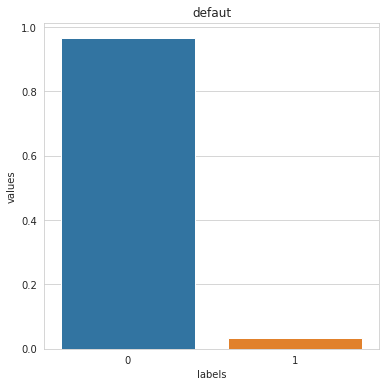

In [177]:
temp = df["defaut"].value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(df)
                  })
plt.figure(figsize = (6,6))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

Target ('defaut') take two levels: 0 wich mean the loan is repaid on time or 1 if not.From the barplot, we see unbalanced class problem ,we should deal with this problem before modeling.

#### DateTime features

the data contains two date features 'DATE_DE_CREATION_TIERS' and 'DATE_DE_CREATION_ENTREP'.The first has no information we drop it and examine the second one.we can set 'NUMTIERS_ANNEE' as index and drop 'NUMTIERS'and 'DATE_DE_CREATION_TIERS'.

In [178]:
df.DATE_DE_CREATION_ENTREP=df.DATE_DE_CREATION_ENTREP.dt.year

In [179]:
df.DATE_DE_CREATION_ENTREP.astype('int64')

NUMTIERS_ANNEE
5200000007513_2015    1982
5200000007513_2016    1982
5200000007934_2015    1953
5200000007934_2017    1953
5200000008051_2015    1995
                      ... 
5200008692041_2019    2012
5200008791992_2016    2015
5200007684315_2018    2013
5200007955060_2019    2006
5200008030705_2015    1990
Name: DATE_DE_CREATION_ENTREP, Length: 1521, dtype: int64

<AxesSubplot:xlabel='defaut', ylabel='DATE_DE_CREATION_ENTREP'>

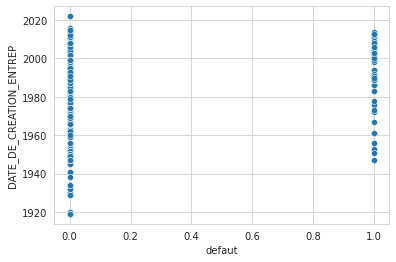

In [180]:
sns.scatterplot(y=df['DATE_DE_CREATION_ENTREP'],x=df['defaut'])

In [181]:
df['DATE_DE_CREATION_ENTREP'].corr(df.defaut)

0.025500528656637468

There is no clear pattern between DATE_DE_CREATION_ENTREP and the target but as the correlation is not null we will keep it now.

### Numeric Features

Now let's deal with numerical features, showing distributions,detection anomalies and the most important the correlations.

#### correlations

<AxesSubplot:>

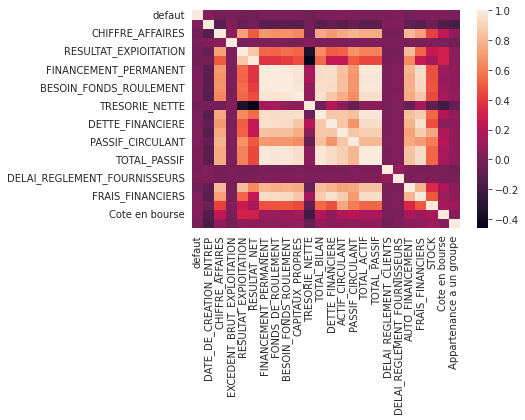

In [182]:
sns.heatmap(df.corr())

The corrplot shows strong correlation between features in the centre,this is helpfull in selecting usefull feature to built a model, but there is week correlation with the target wich need to handle before modeling.

In [183]:
df.corr()['defaut'].sort_values()

TRESORIE_NETTE                 -0.035490
RESULTAT_NET                   -0.034903
AUTO_FINANCEMENT               -0.031689
RESULTAT_EXPlOITATION          -0.025097
CHIFFRE_AFFAIRES               -0.024391
CAPITAUX_PROPRES               -0.009829
FONDS_DE_ROULEMENT             -0.005982
FINANCEMENT_PERMANENT          -0.005048
EXCEDENT_BRUT_EXPLOITATION     -0.004876
TOTAL_BILAN                    -0.004685
BESOIN_FONDS_ROULEMENT         -0.003763
TOTAL_PASSIF                   -0.002544
TOTAL_ACTIF                    -0.002470
Appartenance a un groupe        0.000525
DELAI_REGLEMENT_CLIENTS         0.000988
PASSIF_CIRCULANT                0.002772
DETTE_FINANCIERE                0.003441
FRAIS_FINANCIERS                0.009217
STOCK                           0.012260
DELAI_REGLEMENT_FOURNISSEURS    0.012497
ACTIF_CIRCULANT                 0.012984
Cote en bourse                  0.018326
DATE_DE_CREATION_ENTREP         0.025501
defaut                          1.000000
Name: defaut, dt

correlations with target are very week range(-0.03,0.02).We should not delete them they are usefull to predict in an applicant will repay or not, but transform them and perform feature extraction in order two build a strong model.

#### Feature distribution

In [184]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution(var):
    
    i = 0
    t1 = df.loc[df['defaut'] != 0]
    t0 = df.loc[df['defaut'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8,3,figsize=(16,64))

    for feature in var :
        i += 1
        plt.subplot(8,3,i)
        sns.kdeplot(t1[feature], bw=0.5,color='red',label="defaut = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="defaut = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

<Figure size 432x288 with 0 Axes>

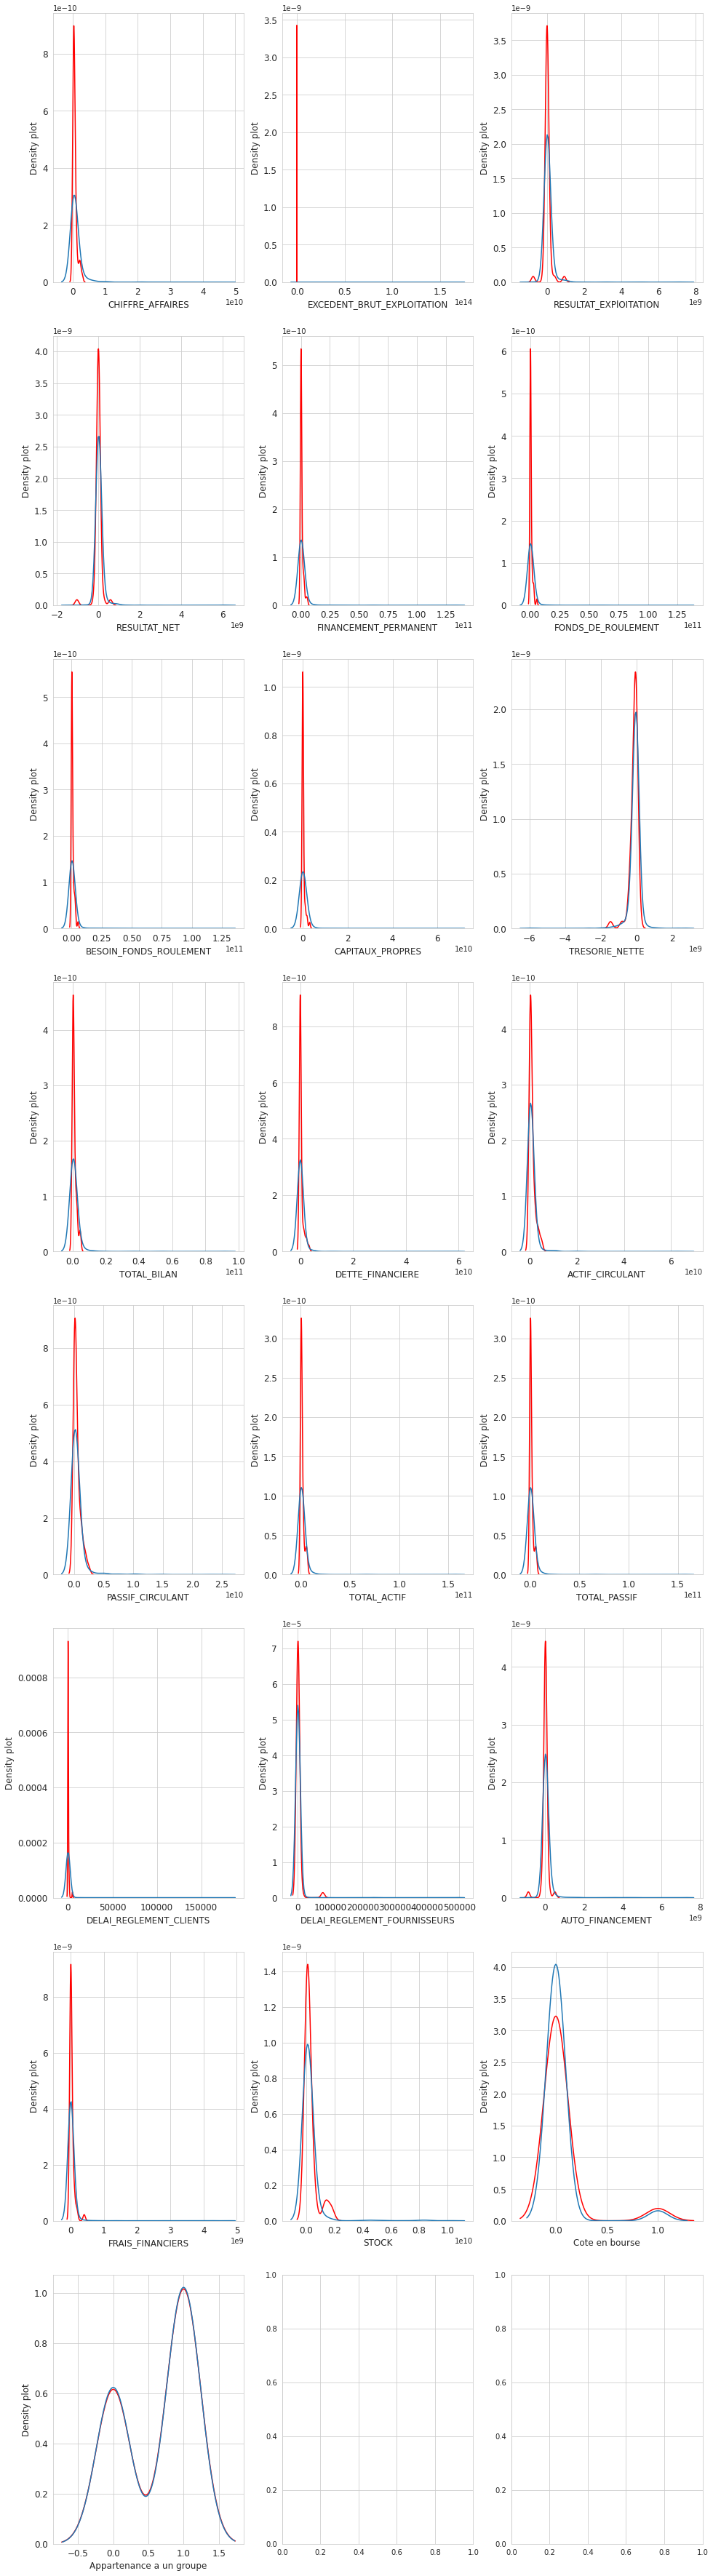

In [185]:
plot_distribution([i for i in numeric_features if i!='defaut'])

most of the numeric features have a low variance and the same distibution with both the two classes of the target ,this is why we found week correlations with the target.

### Categorical Features

In [186]:
df[categories_features].apply(pd.Series.nunique,axis=0).sort_values()

Categorie_juridique                         3
EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT     4
QUALITE_INFORMATION_FINANCIERE              4
STRUCTUREDUMANAGEMENT                       4
POSITIONNEMENTMARCHE                        4
NIVEAU_COMPETITIVITE                        5
REPUTATION                                  5
SUPPORT                                     5
DIVERSITE_FOURNISSEURS                      6
IMPACT_SOCIAUX_ENVIRONNEMENTAL              6
DIVERSITE_CLIENTS                           7
Secteurs                                   17
dtype: int64

Categorical features has few number of modalities (between 3 and 6) else 'Secteurs' wich has 17 modalities.
We need to find a way to deal this!

#### Examine categories

In [187]:
for feature in categories_features:
    if feature != 'NUMTIERS_ANNEE':
        print(feature,' has as modalities',set(df[feature]),'\n')

EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT  has as modalities {'Plus de 10 ans', 'Inferieure e 5 ans', 'Entre 5 et 10 ans', 'Modalite vide'} 

DIVERSITE_CLIENTS  has as modalities {'Diversification très forte par produits,clients, situation geographique', 'Modalite vide', 'Diversification tres forte par produits, clients, situation geographique', 'Bonne diversification par produits mais limitee e une zone geographique ou e quelques client', 'Diversification très forte par produits, clients, situation geographique', 'Forte dependance e quelques clients mais limitee e un seul produit', 'Diversification limitee e un seul client ou un seul produit ou e une seule zone geographique'} 

DIVERSITE_FOURNISSEURS  has as modalities {'Modalite vide', 'Diversite moyenne', 'Pas de diversite', 'Très grande diversite', 'Diversite insufisante', 'Tres grande diversite'} 

IMPACT_SOCIAUX_ENVIRONNEMENTAL  has as modalities {'Aucun impact', 'Fort impact social ou environnemental irreversible', 'Impact social 

We have found some anomalous categories such as 'REPUTATION' has as modality 'Tres bonne' which is the same as the third one 'Très bonne',also 'SUPPORT' has as modality 'Modalite vide'another problem.
Lets change them now.

In [188]:
df['DIVERSITE_CLIENTS'].replace("Diversification tres forte par produits, clients, situation geographique",'Diversification trés forte par produits, clients, situation geographique',inplace=True)
df['DIVERSITE_FOURNISSEURS'].replace('Tres grande diversite','Très grande diversite',inplace=True)
df['DIVERSITE_FOURNISSEURS'].replace('Trés grande diversite','Très grande diversite',inplace=True)
df['REPUTATION'].replace('Tres bonne','Très bonne',inplace=True)
df['NIVEAU_COMPETITIVITE'].replace('Tres forte concurrence','Très forte concurrence',inplace=True)

df['IMPACT_SOCIAUX_ENVIRONNEMENTAL'].replace('Aucun impact social ou environnemental, soumis e une reglementation','Aucun impact social ou environnemental, soumis à une reglementation',inplace=True)

I change the anomalous insertions at first,for the anomaly 'Modality vide' we can't change them now, we need more information to decide with better consedering them as missing values and replace them with n_a or impute them.So let's check how their importance.

#### categorical features dist

In [189]:
def cat_stats(feature,df):
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'value': temp.values})
    cat_perc = df[[feature, 'defaut']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='defaut', ascending=False, inplace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="value",data=df1)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    s = sns.barplot(ax=ax2, x = feature, y='defaut', data=cat_perc)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    plt.show()

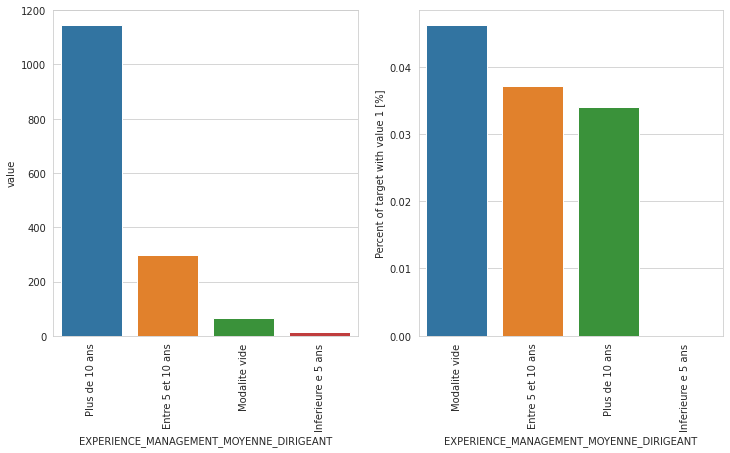

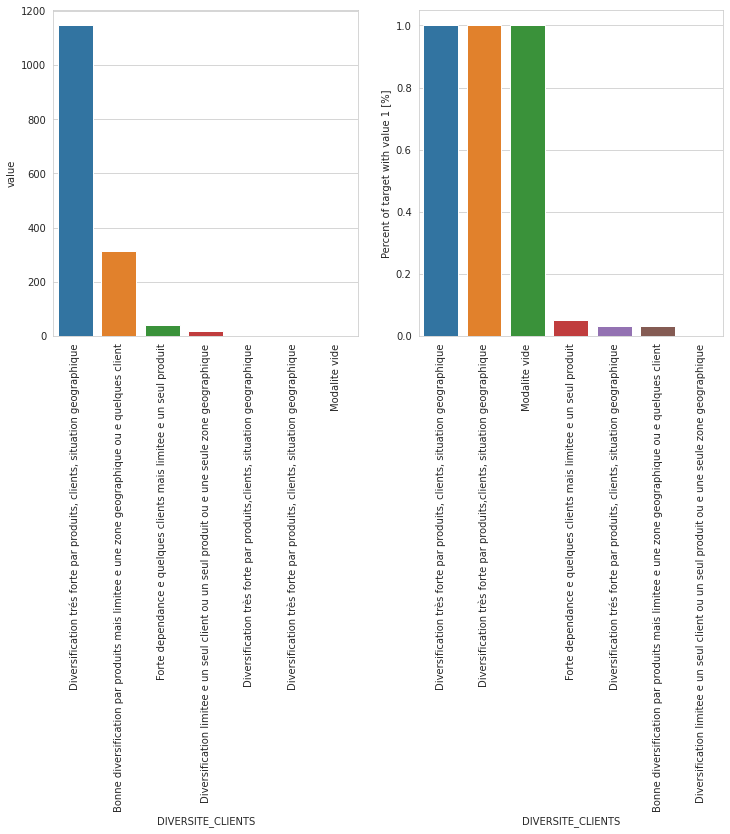

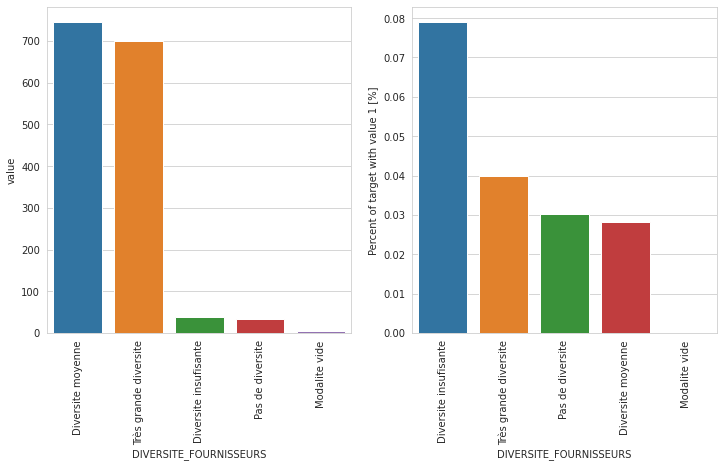

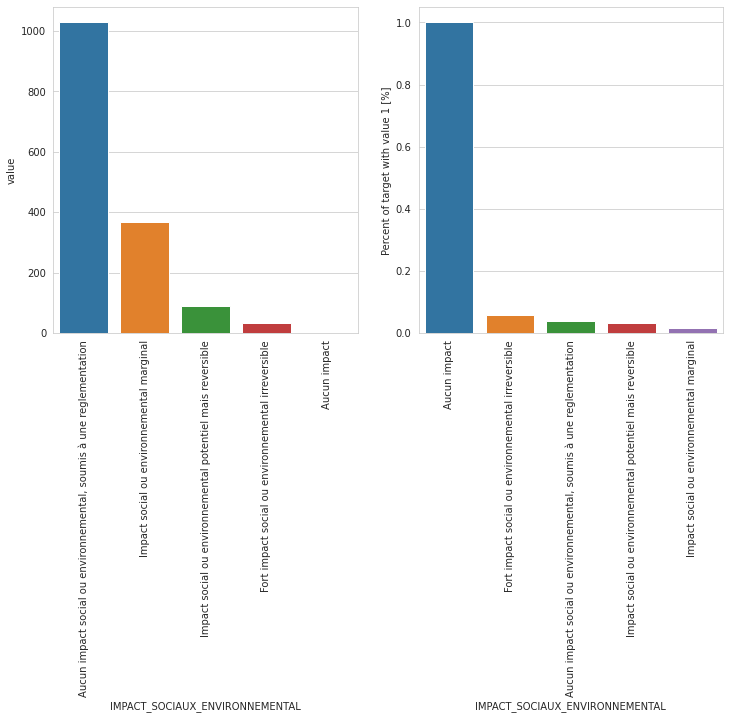

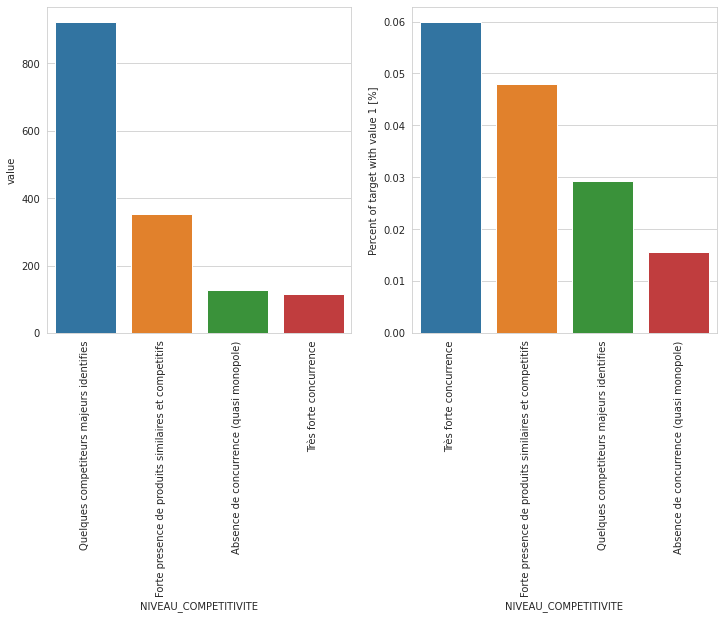

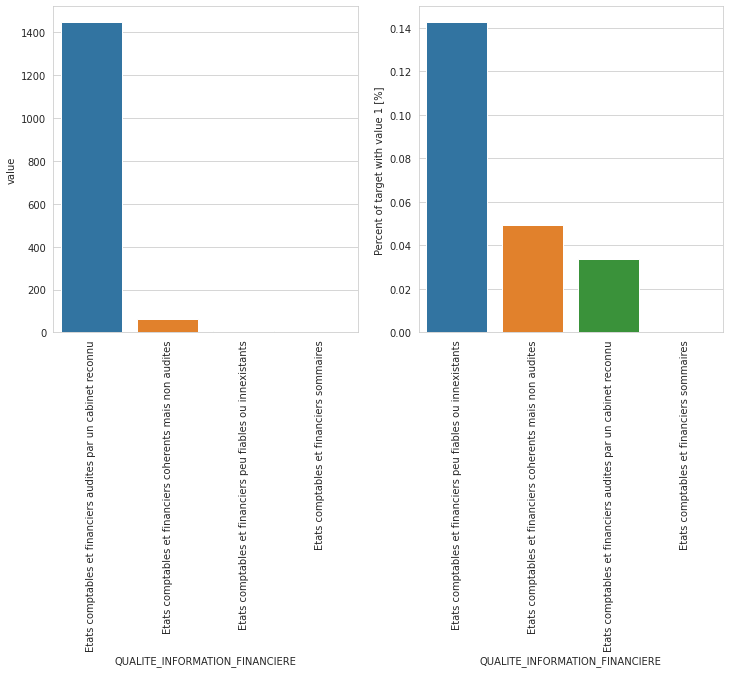

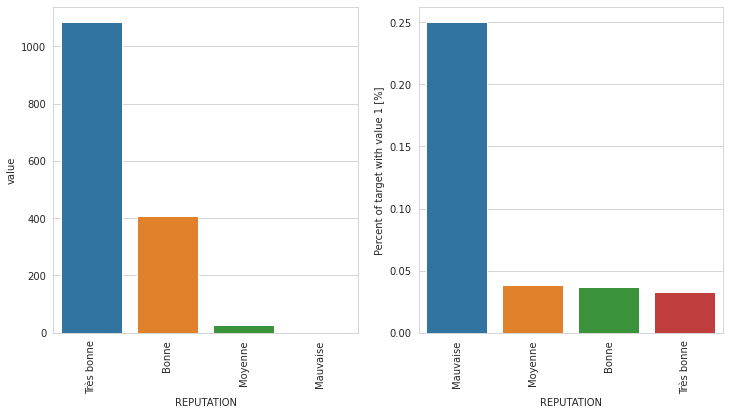

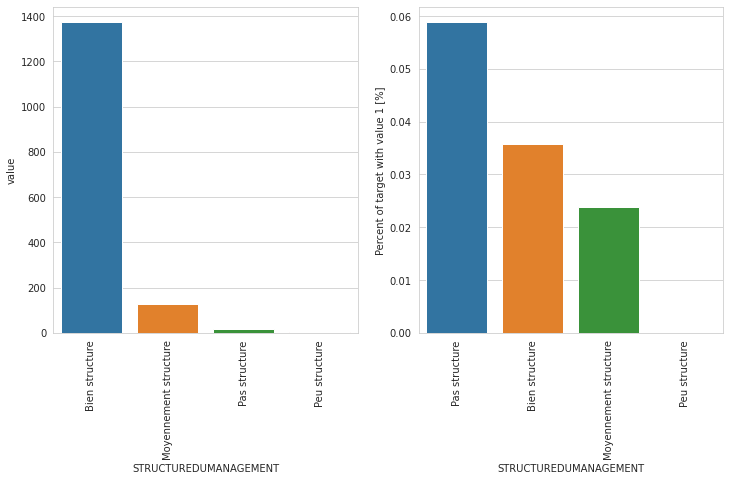

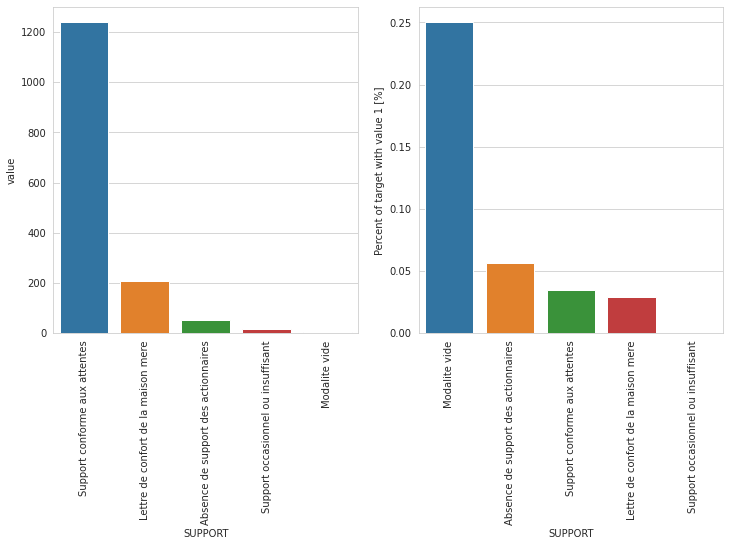

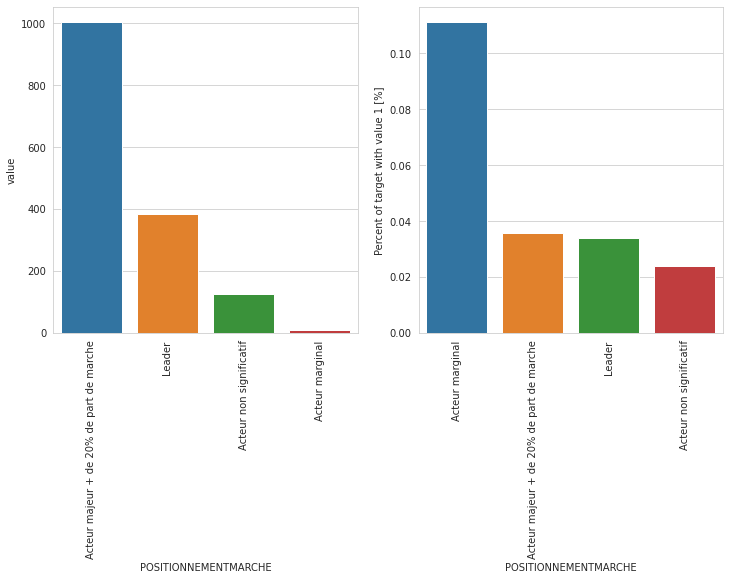

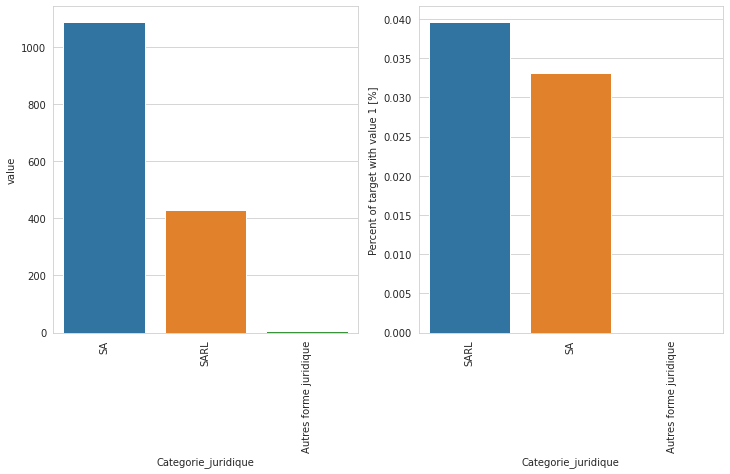

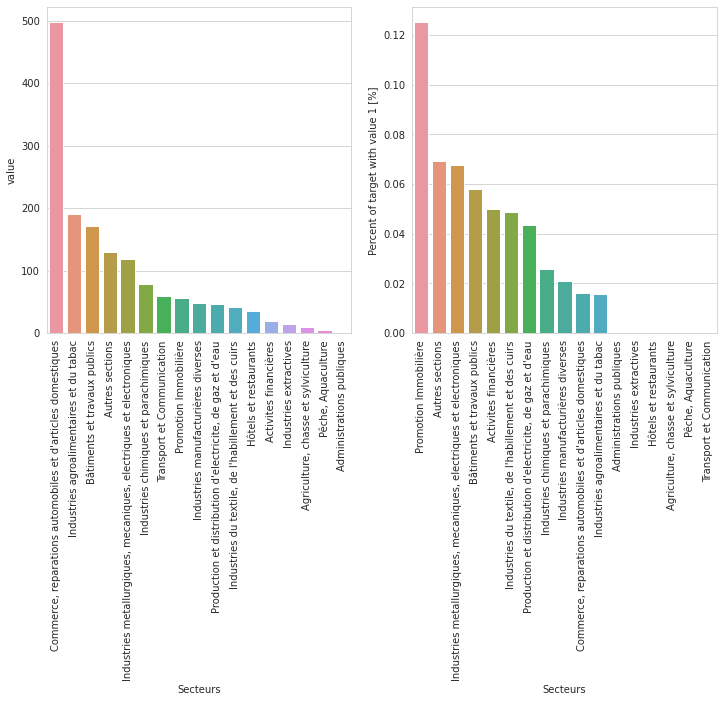

In [190]:
for feature in categories_features:
    cat_stats(feature,df)

Well this plots are very intersting!
let's start by analysing fetures wich have 'Modalite vide',if we focus in it's frequence with the traget(for  features('SUPPORT','EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT'and'DIVERSITE_CLINETS') we find that they they are the most frequent class with the class '1' of the target,we can decide that 'Modalite vide' is imortant in the data so we can impute them instead of removing them.

from this dist we find that the means of groups are significantly different wich we can check it with the anova test,that means such variables are dependent with the target.

In [191]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values='Modalite vide',strategy='most_frequent')
df=pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
df[numeric_features]=df[numeric_features].astype('float64')

Now after dealing with anomalis its important to turn categorical features to numeric type before start modeling,so we will apply LabelEncoding to the ordinal features and OneHotEncoding to the nominal features.

In [226]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
keys = []
tables = []
for variable in categories_features:
    model = ols('defaut ~C({},Sum) '.format(variable), data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    keys.append(variable)
    tables.append(anova_table)

df_anova = pd.concat(tables, keys=keys, axis=0)


print(df_anova)

                                                                                            sum_sq  \
EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT C(EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT, Sum)   0.028818   
                                        Residual                                         51.124370   
DIVERSITE_CLIENTS                       C(DIVERSITE_CLIENTS, Sum)                         2.832712   
                                        Residual                                         48.320476   
DIVERSITE_FOURNISSEURS                  C(DIVERSITE_FOURNISSEURS, Sum)                    1.979376   
                                        Residual                                         49.173813   
IMPACT_SOCIAUX_ENVIRONNEMENTAL          C(IMPACT_SOCIAUX_ENVIRONNEMENTAL, Sum)            2.951976   
                                        Residual                                         48.201212   
NIVEAU_COMPETITIVITE                    C(NIVEAU_COMPETITIVITE, Sum)              

from the anova table we can decide wich categorical features have an impact on the target by selecting only the features whoes p_value is greater than the threshold (0.05).

#### Label Encoding

we perform label encoding only to Ordinal features.

In [196]:
df['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT'].replace(['Plus de 10 ans', 'Entre 5 et 10 ans', 'Inferieure e 5 ans'],(0,1,2),inplace=True)
df['DIVERSITE_FOURNISSEURS'].replace(['Pas de diversite', 'Diversite moyenne', 'Diversite insufisante', 'Très grande diversite'],(0,1,2,3),inplace=True) 
df['REPUTATION'].replace(['Mauvaise', 'Moyenne', 'Bonne', 'Très bonne'],(0,1,2,3),inplace=True)
df['STRUCTUREDUMANAGEMENT'].replace(['Pas structure','Peu structure',  'Moyennement structure' ,'Bien structure'],(0,1,2,3),inplace=True)

#### OneHotEncoding

OneHotEncoding applied to the nominal features

In [197]:
df=pd.get_dummies(df)

we complete the base steps of preprocessing ,so we can jump to the main of the modeling.

## Feature Selection + Model Selection

Feature selection aims to reduce the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. To achieve it we will use the recursive feature elimination technique for selecting the best features that improve the performance of the model .the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

In [198]:
X1=df.copy()
X1=X1.drop('defaut',axis=1)
y1=df['defaut']


At the begining in the EDA section we notice that the data is highly unbalanced,to fix this problem we will use an oversampling technique via SMOTE method to get balanced classes.Its important to apply this method only to the training set to avoid the problem of data leakage.To avoide overfetting we will use Cross_validation technique via RepeatedStratifiedCross validation three times.All this steps will be implement in the pipeline .

In [199]:
#splitting data to train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.25, random_state=27)


Here we will implement three models and check their performance wich help us to decide what should we do in next step.

In [200]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.pipeline import Pipeline #pipeline
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE #for oversampling
from sklearn.metrics import f1_score,classification_report,roc_auc_score # evaluatin metrics

In [201]:
def modeling(model):
    smote=SMOTE(random_state=123)
    rfe = RFE(estimator=model, n_features_to_select=60)
    pipeline = Pipeline(steps=[('smt',smote),('s',rfe),('m',model)])
    pipeline.fit(X_train,y_train)   
    y_pred=pipeline.predict(X_test)
    f1=f1_score(y_pred,y_test,average='weighted')
    roc_auc=roc_auc_score(y_pred,y_test,average='weighted')

    print('confusion_matrix: ','\n',confusion_matrix(y_pred,y_test))
    print('f1_score: ',f1)
    print('roc_auc_score:',roc_auc)

In [202]:
models={'LogisticRegression':LogisticRegression(),'DecisionTreeClassifier':DecisionTreeClassifier(),
        'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis()}
for mod in models.keys():
    print(mod)
    modeling(models[mod])

LogisticRegression
confusion_matrix:  
 [[202   6]
 [167   6]]
f1_score:  0.4116999216495661
roc_auc_score: 0.5029179635393508
DecisionTreeClassifier
confusion_matrix:  
 [[336  12]
 [ 33   0]]
f1_score:  0.8560603564721774
roc_auc_score: 0.4827586206896552
LinearDiscriminantAnalysis
confusion_matrix:  
 [[264   8]
 [105   4]]
f1_score:  0.6069725290475796
roc_auc_score: 0.5036427415002699


well! DecesionTree perform the best from the others and has f1_score 0.94.
from these results we can say that simple models need a lot of tuning to perform better wich is not pertinent so we need a sofisticated model .we will use DecisionTree as a base estimator.

### Ensemble Method

to try and beat the poor performance of our baseline,we can update the algorithm so we will use two types of ensembling :bagging(RandomForest)wich runs a lot of trees independly and combine them by averaging,second the boosting (via CatBoost) wich starts from a weak learner and boost it until rich a high performance.

#### RandomForest

In [203]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from numpy import mean
from numpy import std
smote=SMOTE(random_state=123)
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=50)
model = RandomForestClassifier()
pipeline1 = Pipeline(steps=[('smt',smote),('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores_f1 = cross_val_score(pipeline1, X1, y1, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
n_scores_roc_auc = cross_val_score(pipeline1, X1, y1, scoring='roc_auc_ovo_weighted', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('f1_score: %.3f (%.3f)' % (mean(n_scores_f1), std(n_scores_f1)))
print('roc_auc_score: %.3f (%.3f)' % (mean(n_scores_roc_auc), std(n_scores_roc_auc)))

f1_score: 0.946 (0.006)
roc_auc_score: 0.689 (0.098)


In [207]:
#RandomForest without cross validation
smote=SMOTE(random_state=123)
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=90)
model = RandomForestClassifier()
pipeline1 = Pipeline(steps=[('smt',smote),('s',rfe),('m',model)])
pipeline1.fit(X_train,y_train)
y_pred=pipeline1.predict(X_test)
f1=f1_score(y_pred,y_test,average='weighted')
roc_auc=roc_auc_score(y_pred,y_test,average='weighted')

print(confusion_matrix(y_pred,y_test))
print(f1)
print(roc_auc)

[[368  12]
 [  1   0]]
0.9800644078368709
0.4842105263157895


#### CatBoost

In [204]:
#oversampling the minority class
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_train[df_train.defaut==0]
df_minority = df_train[df_train.defaut==1]
# oversample minority class z
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=len(df_majority),   
                                 random_state=1234) 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.defaut.value_counts()
X_train=df_upsampled.drop('defaut',axis=1)  
y_train=df_upsampled['defaut']

In [205]:
from catboost import CatBoostClassifier
catboost=CatBoostClassifier(iterations=100,
                           depth=16,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
catboost.fit(X_train,y_train)
y_pred=catboost.predict(X_test)
f1=f1_score(y_pred,y_test,average='weighted')
roc_auc=roc_auc_score(y_pred,y_test,average='weighted')

print(confusion_matrix(y_pred,y_test))
print(f1)
print(roc_auc)

0:	learn: 0.1403223	total: 2.6s	remaining: 4m 17s
1:	learn: 0.0561185	total: 5.18s	remaining: 4m 14s
2:	learn: 0.0330909	total: 7.79s	remaining: 4m 12s
3:	learn: 0.0245937	total: 10.5s	remaining: 4m 12s
4:	learn: 0.0187339	total: 13.2s	remaining: 4m 11s
5:	learn: 0.0152743	total: 15.8s	remaining: 4m 7s
6:	learn: 0.0129341	total: 18.4s	remaining: 4m 3s
7:	learn: 0.0113159	total: 20.9s	remaining: 3m 59s
8:	learn: 0.0100265	total: 23.5s	remaining: 3m 57s
9:	learn: 0.0091209	total: 26s	remaining: 3m 54s
10:	learn: 0.0084180	total: 28.6s	remaining: 3m 51s
11:	learn: 0.0078122	total: 31.3s	remaining: 3m 49s
12:	learn: 0.0073012	total: 33.9s	remaining: 3m 46s
13:	learn: 0.0068695	total: 36.4s	remaining: 3m 43s
14:	learn: 0.0064642	total: 39.1s	remaining: 3m 41s
15:	learn: 0.0060945	total: 41.8s	remaining: 3m 39s
16:	learn: 0.0057788	total: 44.4s	remaining: 3m 37s
17:	learn: 0.0054935	total: 47.1s	remaining: 3m 34s
18:	learn: 0.0052368	total: 49.7s	remaining: 3m 31s
19:	learn: 0.0050126	total:

let's compare the tow Meta_estimators:Catboost missclassied 11 from '0' class and one from '1'class and have f1_score 0.915 ,RandomForest missclassified only one from class '0' from the hole test set .we can say now that RandomForest is the best estimator we have built.

but is this the end ? of course No,ower model can perform more better(in other test sets) if we tune it.let's tune it now.

### Model Tuning

Model tuning is the systematic modification of model parameters to identify the most performant model.it stands for chosing the best parameters to reach higher score. to do this we will use the GridSearchCV

In [252]:
from sklearn.model_selection import GridSearchCV
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "s__n_features_to_select": [50,70,90],
    "m__n_estimators": [50,100,150],
}
search = GridSearchCV(pipeline1, param_grid,scoring='roc_auc_ovo_weighted', n_jobs=2)
search.fit(X1, y1)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



Best parameter (CV score=0.691):
{'m__n_estimators': 100, 's__n_features_to_select': 50}


To conclude, we found than the best model is based on RandomForestClassifier with best parameters {'m__n_estimators': 100, 's__n_features_to_select': 50} and have auc_score 0.691.